In [372]:
# MLflow
import mlflow
from mlflow.models import infer_signature

# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualizations
import matplotlib.pyplot as plt

# math functions
import numpy as np

# read CSV file
import os
import glob

# data frames
import pandas as pd

# regexes
import re

# Print pandas.describe() in PDF
from prettytable import PrettyTable

# converting created dates from reddit API into human readable format
from datetime import datetime, timedelta

In [373]:
# Disable automated output
import warnings
# Future deprecation warnings
warnings.filterwarnings("ignore")
import logging
# Set logging level to suppress INFO messages
logging.getLogger('mlflow').setLevel(logging.WARNING)

In [374]:
# https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6

# Load NLTK Libraries

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# Downloading NLTK's databases
nltk.download('vader_lexicon', quiet=True); # get lexicons data
nltk.download('punkt', quiet=True); # for tokenizer
nltk.download('stopwords', quiet=True); # dictionary for tokenization


In [375]:
# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

# Reddit Subreddit API analysis

Subreddit Stats
+----------------------+-------+------------+-------------+----------------------+-----------------+
|         name         | index | Unnamed: 0 | subscribers |     display_name     | subscribers_pct |
+----------------------+-------+------------+-------------+----------------------+-----------------+
|       chatgpt        |   7   |     7      |   4491408   |       chatgpt        |      36.51      |
|   machinelearning    |   4   |     4      |   2870084   |   MachineLearning    |      23.33      |
|     datascience      |   8   |     8      |   1362754   |     datascience      |      11.08      |
|        openai        |   5   |     5      |   1120060   |        OpenAI        |       9.11      |
|         gpt3         |   2   |     2      |    720336   |         GPT3         |       5.86      |
|      artificial      |   6   |     6      |    718553   |      artificial      |       5.84      |
| learnmachinelearning |   11  |     11     |    384248   | learnmachinelea

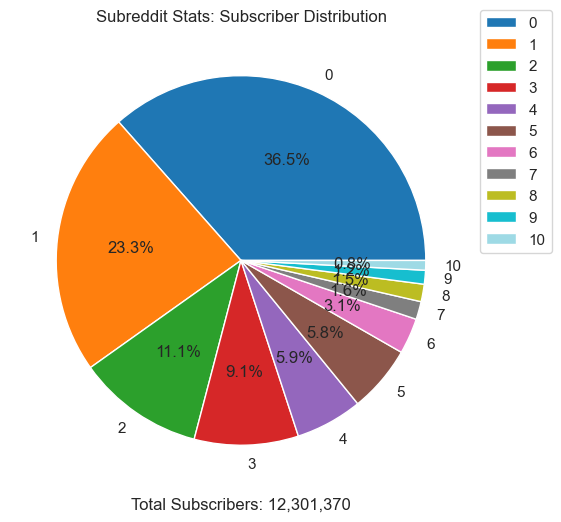

In [376]:
# Reddit metadata structure
subreddit_dict = {  "name":[],
                    "subscribers":[] }

# Import subreddit metadata
metadata = pd.DataFrame()
for fname in glob.iglob(os.path.abspath('./output/**/*.meta'), recursive=True):
    _metadata = pd.read_csv(fname)
    metadata = metadata.append(_metadata.copy())
    #print(fname)
    #break #DEBUG

print('Subreddit Stats')
# Create a PrettyTable object
table = PrettyTable()
# Add columns to the table
table.field_names = metadata.columns
# Add rows to the table
for row in metadata.itertuples(index=False):
    # Set the float format for all float columns
    float_format = "{:.2f}"
    # Format float values
    row = [float_format.format(value) if isinstance(value, float) else value for value in row]
    table.add_row(row)
# Print the table
print(table)

# Plot pie chart of sentiment label distribution
plt.figure(figsize=(8, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(metadata)))
metadata['subscribers_pct'].plot(kind='pie', autopct='%1.1f%%', colors=colors)
# Add annotations for subscriber percentages
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.title('Subreddit Stats: Subscriber Distribution')
plt.ylabel('')
plt.xlabel('Total Subscribers: ' + "{:,}".format(metadata['subscribers'].sum()))
plt.show()

# Reddit Search API data analysis

In [377]:
# Reddit data structure
topics_dict_template = {"subreddit":[],
                        "query":[],
                        "sort":[],
                        "date":[],
                        "title":[],
                        "author":[],
                        "stickied":[],
                        "upvote_ratio":[],
                        "score":[],
                        "id":[],
                        "url":[],
                        "num_comments": [],
                        "created": [],
                        "body":[]}

# Import query data
df = {}
running_total = 0
for fname in glob.glob(os.path.abspath('./output/**/*.csv'), recursive=True):
    filename = os.path.splitext(os.path.basename(fname))[0]
    _df=pd.read_csv(fname)
    _df['date'] = pd.to_datetime(_df['date']) # convert date column
    _df['date'] = pd.to_datetime(_df['date']) # convert date column
    _df['date'] = pd.to_datetime(_df['date']) # convert date column
    df[filename] = pd.DataFrame(_df)
    running_total+=len(_df)
    #print(fname)
    #print(running_total)
    #break #DEBUG

print(f"Total imported Reddit posts: {running_total}")

Total imported Reddit posts: 1528


In [378]:
# Filter this comment
df['gpt3-after'] = df['gpt3-after'][df['gpt3-after']['id'] != 'z9yhzj']

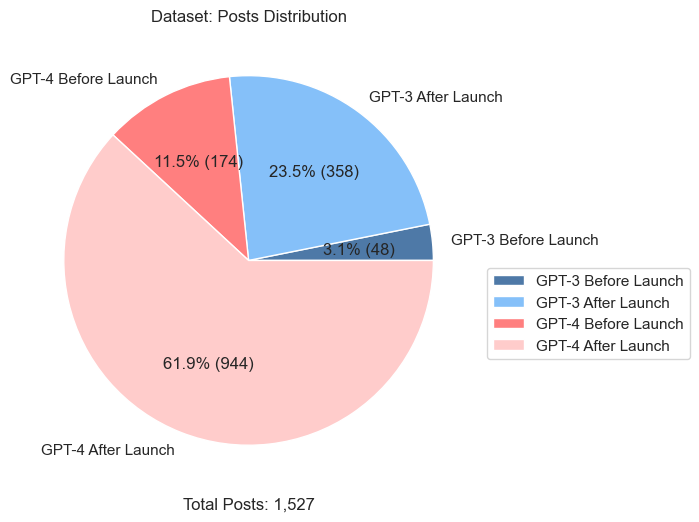

In [379]:
# Define the date range for GPT-3 hype analysis
gpt3_start = datetime(2022, 11, 1)
gpt3_launch = datetime(2022, 11, 30)
gpt3_end = datetime(2023, 1, 31)

# Define the date range for GPT-4 hype analysis
gpt4_start = datetime(2023, 2, 15)
gpt4_launch =  datetime(2023, 3, 14)
gpt4_end = datetime(2023, 5, 15)

# Split at gpt3_launch date
df_gpt3_before = df['gpt3-before']
df_gpt3_after = df['gpt3-after']
# Split at gpt4_launch date
df_gpt4_before = df['gpt4-before']
df_gpt4_after = df['gpt4-after']

# get the distance of the date to the launch date for this dataset
def add_launch_distance_lin(dataset, launch_date):
    dataset['launch_passed'] = abs(launch_date - dataset['date'])
    dataset['launch_distance'] = abs(launch_date - dataset['date'])
    dataset['launch_distance_f'] = dataset['launch_distance'] / pd.to_timedelta(1, unit='D')
    dataset['launch_distance_lin'] = launch_date - dataset['date']
    dataset['launch_distance_lin_f'] = dataset['launch_distance_lin'] / pd.to_timedelta(1, unit='D')
    dataset['launch_passed'] = dataset['launch_distance_lin_f'] >= 0

# Add the linear launch distance to each dataset
add_launch_distance_lin(df_gpt3_before, gpt3_launch)
add_launch_distance_lin(df_gpt3_after, gpt3_launch)
add_launch_distance_lin(df_gpt4_before, gpt4_launch)
add_launch_distance_lin(df_gpt4_after, gpt4_launch)

# Get counts of datasets before and after launch dates
df_gpt_counts = {
    'GPT-3 Before Launch': len(df_gpt3_before),
    'GPT-3 After Launch': len(df_gpt3_after),
    'GPT-4 Before Launch': len(df_gpt4_before),
    'GPT-4 After Launch': len(df_gpt4_after)
}
# Plot pie chart of GPT search distribution
plt.figure(figsize=(8, 6))
colors = ['#4e79a7', '#85c0f9', '#ff7f7f', '#ffcccb']  
plt.pie(df_gpt_counts.values(), colors=colors, labels=df_gpt_counts.keys(), autopct=lambda pct: f"{pct:.1f}% ({int(pct/100*sum(df_gpt_counts.values()))})")
# Add annotations for subscriber percentages
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Dataset: Posts Distribution')
plt.ylabel('')
plt.xlabel('Total Posts: ' + "{:,}".format(sum(df_gpt_counts.values())))
plt.show()

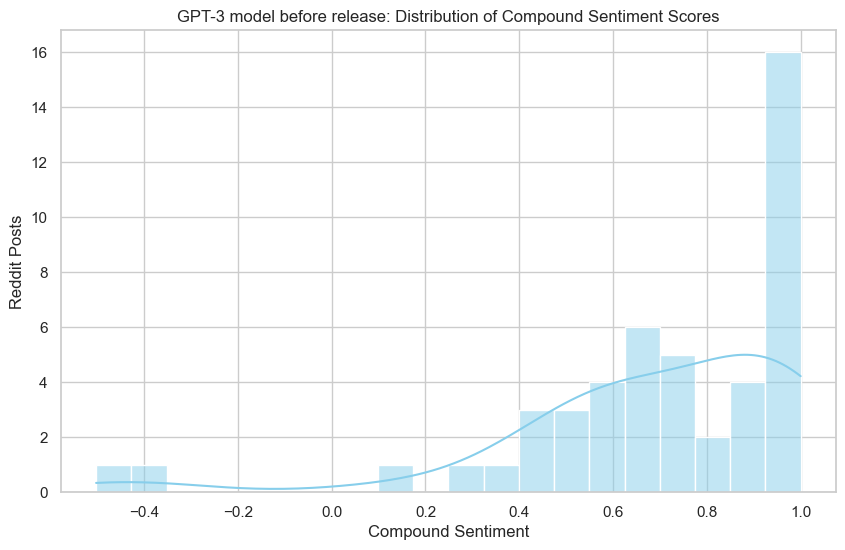

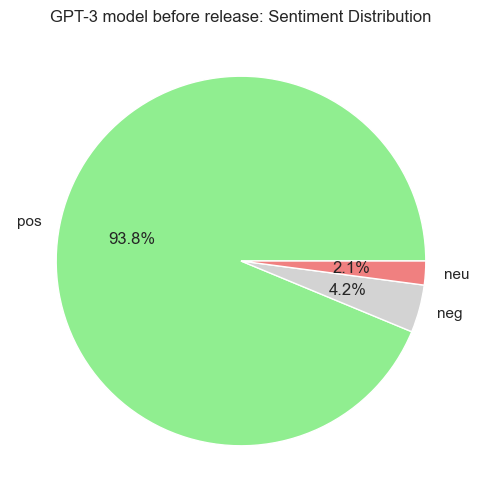

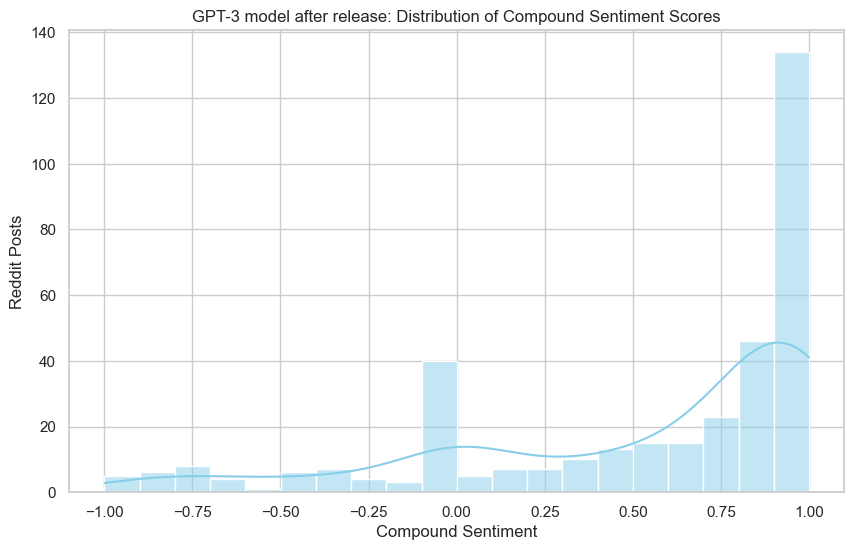

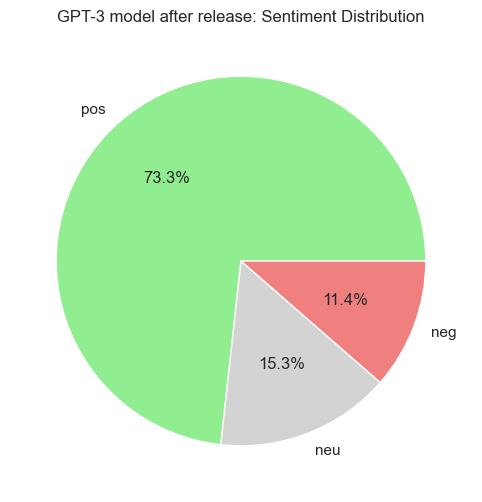

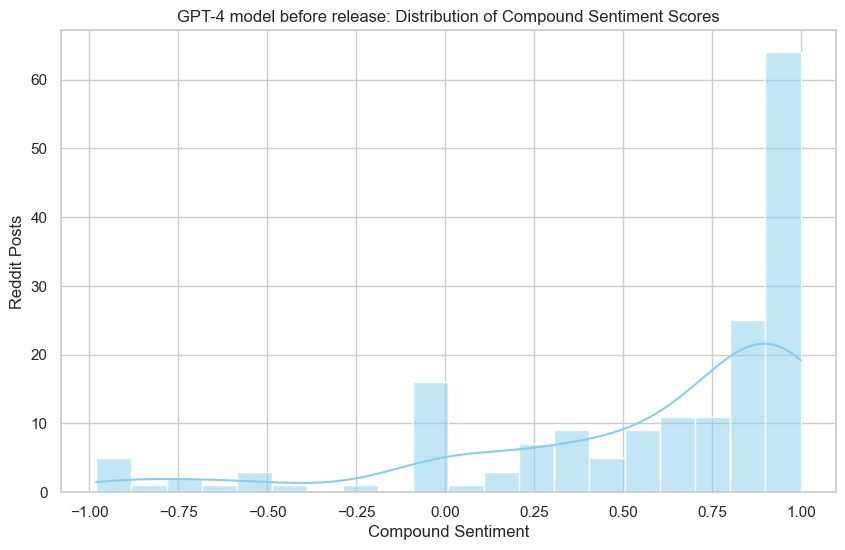

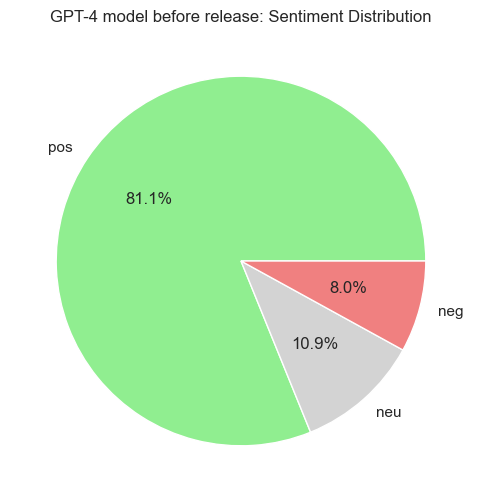

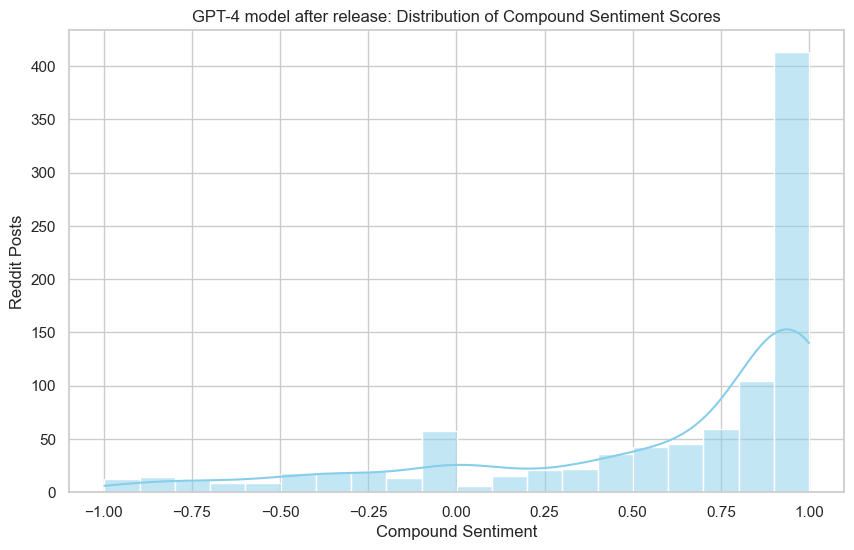

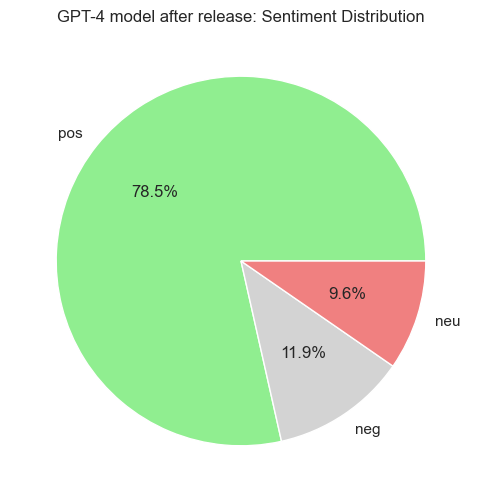

In [380]:
def visualize_sentiment(dataset, name):
    # Plot histogram of compound sentiment scores
    plt.figure(figsize=(10, 6))
    sns.histplot(data=dataset, x='compound', bins=20, kde=True, color='skyblue')
    plt.title(name + ': Distribution of Compound Sentiment Scores')
    plt.xlabel('Compound Sentiment')
    plt.ylabel('Reddit Posts')
    plt.show()

    # Plot pie chart of sentiment label distribution
    plt.figure(figsize=(8, 6))
    dataset['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightgray', 'lightcoral'])
    plt.title(name + ': Sentiment Distribution')
    plt.ylabel('')
    plt.show()
visualize_sentiment(dataset=df_gpt3_before, name='GPT-3 model before release')
visualize_sentiment(dataset=df_gpt3_after, name='GPT-3 model after release')
visualize_sentiment(dataset=df_gpt4_before, name='GPT-4 model before release')
visualize_sentiment(dataset=df_gpt4_after, name='GPT-4 model after release')

# Time Series Analysis

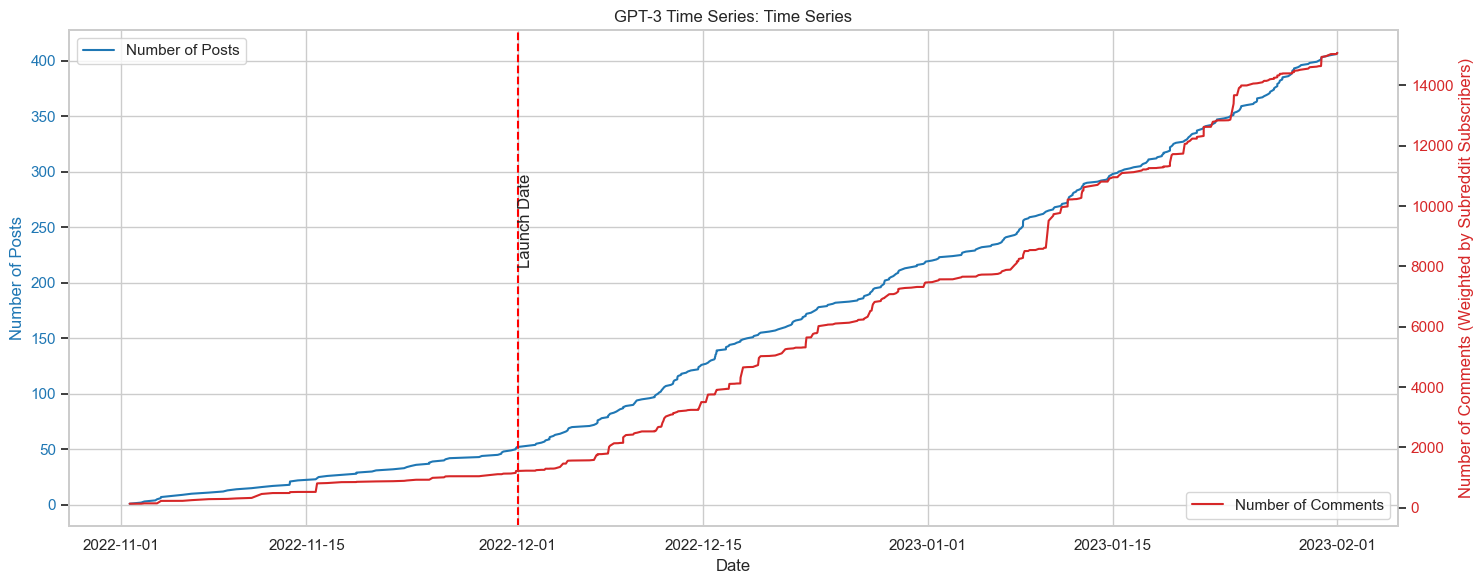

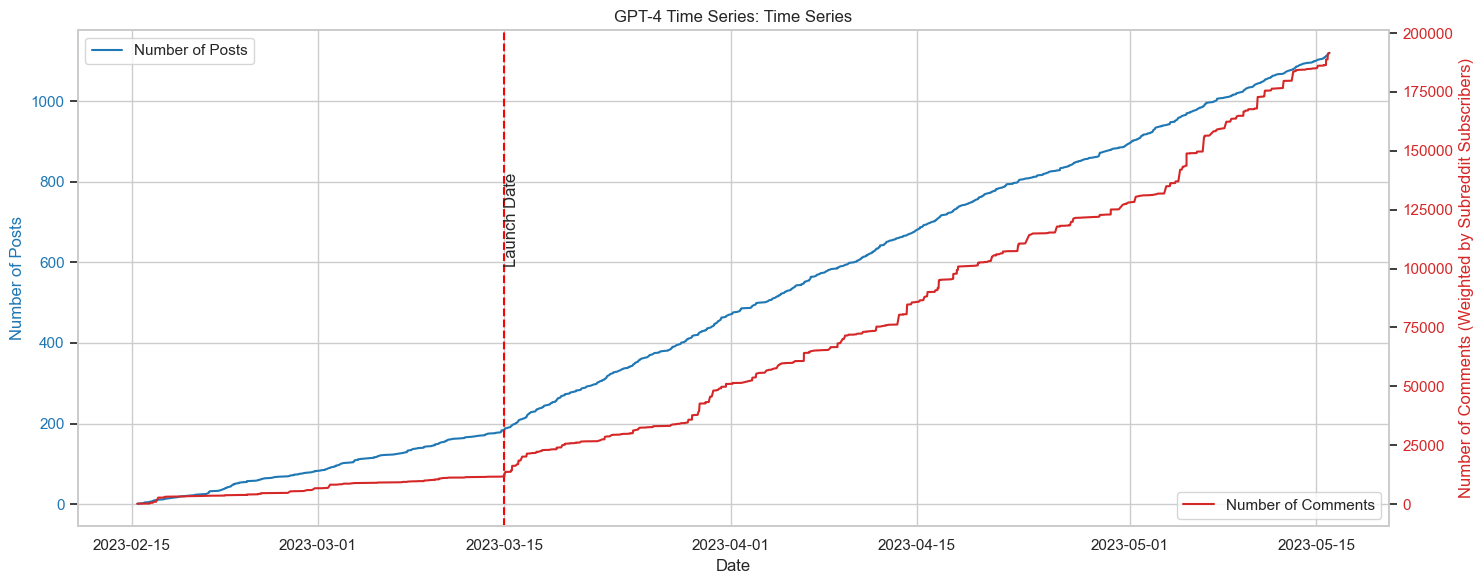

In [381]:
def plot_model_time_series(model, model_name, launch_date):
    model['count_cumulative'] = model['date'].apply(lambda date: len(model[model['date'] <= date]))
    model['num_comments_cumulative'] = model['num_comments_weighted'].cumsum()
    
    fig, ax1 = plt.subplots(figsize=(15, 6))  # Create figure and axes
    
    # Plot cumulative posts per day
    ax1.plot(model['date'], model['count_cumulative'], color='tab:blue', label='Number of Posts')
    ax1.set_ylabel('Number of Posts', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Create a second y-axis for number of comments
    ax2 = ax1.twinx()
    ax2.plot(model['date'], model['num_comments_cumulative'], color='tab:red', label='Number of Comments')
    ax2.set_ylabel('Number of Comments (Weighted by Subreddit Subscribers)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='lower right')  # Show legend for comments
    
    ax1.set_title(model_name + ': Cumulative Trends for Posts and Comments')
    ax1.set_xlabel('Date')
    ax1.axvline(x=launch_date + timedelta(days=1), color='r', linestyle='--')  # Vertical line for launch date
    ax1.text(launch_date + timedelta(days=1), ax1.get_ylim()[1] * .5, 'Launch Date', rotation=90, verticalalignment='bottom')
    ax1.legend(loc='upper left')  # Show legend for posts
    
    ax2.grid(False)  # Remove y-axis gridlines
    
    plt.tight_layout()
    plt.show()

# Plot GPT-3 data by date
df_gpt3_time_series = pd.concat([df_gpt3_before, df_gpt3_after]).sort_values(by='date')
plot_model_time_series(df_gpt3_time_series, 'GPT-3 Time Series', gpt3_launch)

# Plot GPT-4 data by date
df_gpt4_time_series = pd.concat([df_gpt4_before, df_gpt4_after]).sort_values(by='date')
plot_model_time_series(df_gpt4_time_series, 'GPT-4 Time Series', gpt4_launch)

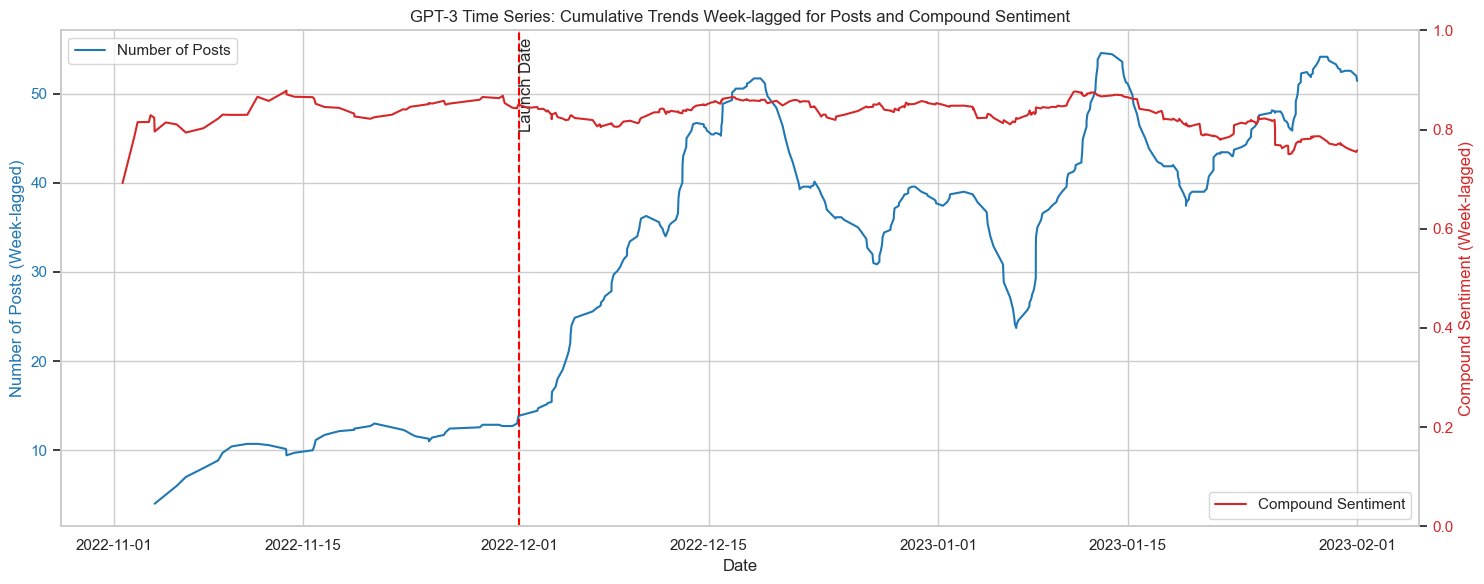

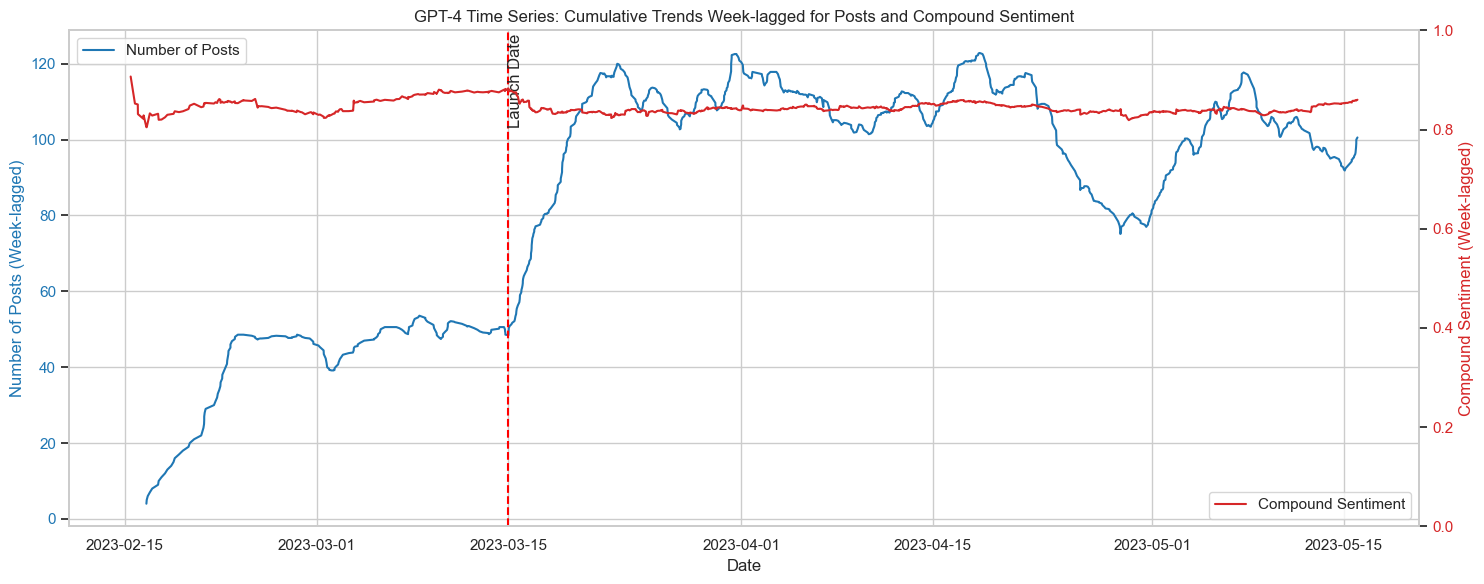

In [432]:
def plot_time_series_lagged(model, model_name, launch_date):
    # Sort by date
    _model = model.sort_values(by='date')

    # Calculate the total comments for the past week, then take the lagged average for that week
    _model['count_cumulative'] = _model['date'].apply(lambda date: len(_model[
        (date - timedelta(days=7) < _model['date']) & (_model['date'] <= date)
    ]))
    _model['count_cumulative_lagged'] = _model['count_cumulative'].rolling(window=7).mean()

    # Calculate the average sentiment for the past week, then take the lagged average for that week
    _model['compound_cumulative'] = _model['date'].apply(lambda date: _model[
        (date - timedelta(days=7) < _model['date']) & (_model['date'] <= date)
    ]['neg'].mean())
    _model['compound_cumulative_lagged'] = _model['compound_cumulative'].rolling(window=7).mean()

    fig, ax1 = plt.subplots(figsize=(15, 6))  # Create figure and axes
    
    # Plot cumulative posts per day
    ax1.plot(_model['date'], _model['count_cumulative_lagged'], color='tab:blue', label='Number of Posts')
    ax1.set_ylabel('Number of Posts (Week-lagged)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Create a second y-axis for number of comments
    ax2 = ax1.twinx()
    ax2.plot(_model['date'], _model['compound_cumulative'], color='tab:red', label='Compound Sentiment')
    ax2.set_ylabel('Compound Sentiment (Week-lagged)', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='lower right')  # Show legend for comments
    ax2.set_ylim(0, 1)  # Set y-axis limits for compound sentiment
    
    ax1.set_title(model_name + ': Cumulative Trends Week-lagged for Posts and Compound Sentiment')
    ax1.set_xlabel('Date')
    ax1.axvline(x=launch_date + timedelta(days=1), color='r', linestyle='--')  # Vertical line for launch date
    ax1.text(launch_date + timedelta(days=1), ax1.get_ylim()[1] * .8, 'Launch Date', rotation=90, verticalalignment='bottom')
    ax1.legend(loc='upper left')  # Show legend for posts
    
    ax2.grid(False)  # Remove y-axis gridlines
    
    plt.tight_layout()
    plt.show()
    return _model

# Plot GPT-3 data by date
df_gpt3_time_series = plot_time_series_lagged(pd.concat([df_gpt3_before, df_gpt3_after]), 'GPT-3 Time Series', gpt3_launch)

# Plot GPT-4 data by date
df_gpt4_time_series = plot_time_series_lagged(pd.concat([df_gpt4_before, df_gpt4_after]), 'GPT-4 Time Series', gpt4_launch)

In [430]:
df_gpt3_time_series[['clean','compound','pos','neu','neg']]

,clean,compound,pos,neu,neg
0,"C'mon people, let's stop wasting loads of mon...",0.9999,0.023,0.285,0.692
1,&x200B;\n\n\n\n \n\nI stumbled upon this diagr...,0.7130,0.024,0.097,0.880
2,I was planning on pitching some of the stuff t...,0.7269,0.000,0.127,0.873
3,"Hello,\n\nIf you are interested in automatic s...",0.8313,0.000,0.184,0.816
4,"Hello everyone, \n\nI have been building this...",0.6275,0.035,0.081,0.884
...,...,...,...,...,...
185,I’m an ML Engineer at Hive AI and I’ve been wo...,0.9184,0.000,0.161,0.839
186,"Hey all, so like everyone else who uses Excel,...",0.9562,0.104,0.249,0.647
187,I want to train gpt on several books which I n...,0.9865,0.015,0.203,0.782
188,[Pickaxe]( is an awesome no-code tool that let...,0.7096,0.000,0.102,0.898


In [ ]:
def text_blob_sentiment(dataset):
    # VADER sentiment analysis
    sid = SentimentIntensityAnalyzer()

    dataset[['pos', 'neg', 'neu', 'compound']] = dataset['clean'].apply(lambda text: pd.Series(sid.polarity_scores(text)))

    # Threshold conditions determine the value of the sentiment of the text
    THRESHOLD = 0.2
    conditions = [
        (dataset['compound'] <= -THRESHOLD),
        (dataset['compound'] > -THRESHOLD) & (dataset['compound'] < THRESHOLD),
        (dataset['compound'] >= THRESHOLD),
        ]
    values = ["neg", "neu", "pos"]
    dataset['label'] = np.select(conditions, values)

    # Convert all sentiment columns to numeric type
    dataset[['pos', 'neg', 'neu', 'compound']] = dataset[['pos', 'neg', 'neu', 'compound']].apply(pd.to_numeric, errors='coerce')


# Preparing datasets, features, and targets

In [382]:
# Features to measure with MLflow
feature_names = ['score_weighted', 'stickied', 'upvote_ratio', 'created', 'compound', 'pos', 'neg', 'neu']
# Target MLflow value
target_name = 'num_comments_weighted'
# these variables should be represented as log of the original values
log_variables = ['score_weighted','num_comments', 'num_comments_weighted']

for variable in log_variables:
    # Rename the variables to log_[variable] in the datasets
    log_variable = 'log_'+variable
    if target_name == variable:
        target_name = log_variable
    elif variable in feature_names:
        feature_names[feature_names.index(variable)] = log_variable
def clean_dataset(dataset, inplace=True):
    global log_variables, feature_names, target_name
    if inplace is True:
        _dataset = dataset
    else:
        _dataset = dataset.copy()
    for variable in log_variables:
        # Rename the variables to log_[variable] in the datasets
        log_variable = 'log_'+variable
        _dataset[log_variable] = _dataset[variable].apply(lambda value: np.log(value+1))

clean_dataset(df_gpt3_before)
clean_dataset(df_gpt3_after)
clean_dataset(df_gpt4_before)
clean_dataset(df_gpt4_after)

# These features are disabled. Stickied items throw off the counts.
for feature in ['stickied', 'created', 'pos', 'neg', 'neu']: feature_names.remove(feature)

print(f"feature_names={feature_names}")
print(f"target_name={target_name}")

feature_names=['log_score_weighted', 'upvote_ratio']
target_name=log_num_comments_weighted


In [383]:
def describe_dataset(dataset, name):
    print(name)
    description_table = dataset.describe()

    # Convert the 'created' column to datetime
    description_table['created'] = pd.to_datetime(description_table['created'], unit='s')

    description_table = description_table.transpose()
    description_table.reset_index(inplace=True)

    # Create a PrettyTable object for the first half of columns
    table1 = PrettyTable()
    table1.field_names = description_table.columns[:1+len(description_table.columns)//2]

    # Create a PrettyTable object for the second half of columns, including the first column
    table2 = PrettyTable()
    table2.field_names = ['index'] + list(description_table.columns[1+len(description_table.columns)//2:])

    # Set the float format for all float columns
    float_format = "{:.2f}"

    # Set the timedelta format
    def format_timedelta(td):
        days = td.days
        hours, remainder = divmod(td.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return f"{days} days" # {hours:02}:{minutes:02}:{seconds:02}
    
    # Format date
    def format_date(dt):
        return dt.strftime("%Y-%m-%d") # %H:%M:%S

    # Add rows to the tables
    for row in description_table.itertuples(index=False):
        # Convert timedelta values to formatted strings
        row = list(row)
        for i, value in enumerate(row):
            if isinstance(value, pd.Timedelta):
                row[i] = format_timedelta(value)
            elif isinstance(value, pd.Timestamp):
                row[i] = format_date(value)
        # Format float values
        row = [float_format.format(value) if isinstance(value, float) else value for value in row]
        # Add row to the first table
        table1.add_row(row[:1+len(description_table.columns)//2])
        # Add row to the second table
        table2.add_row([row[0]] + row[1+len(description_table.columns)//2:])

    # Print the tables
    print(table1)
    print(table2)

describe_dataset(dataset=df_gpt3_before, name='GPT-3 model before release')
describe_dataset(dataset=df_gpt3_after, name='GPT-3 model after release')
describe_dataset(dataset=df_gpt4_before, name='GPT-4 model before release')
describe_dataset(dataset=df_gpt4_after, name='GPT-4 model after release')

GPT-3 model before release
+---------------------------+------------+------------+------------+------------+
|           index           |   count    |    mean    |    std     |    min     |
+---------------------------+------------+------------+------------+------------+
|           index           |   48.00    |  4229.77   |  1655.79   |   182.00   |
|         Unnamed: 0        |   48.00    |   59.29    |   43.12    |    1.00    |
|        upvote_ratio       |   48.00    |    0.86    |    0.16    |    0.50    |
|           score           |   48.00    |   45.90    |   96.08    |    0.00    |
|        num_comments       |   48.00    |   20.00    |   38.09    |    0.00    |
|          created          | 1970-01-01 | 2022-11-16 | 1970-01-09 | 2022-11-01 |
|       score_weighted      |   48.00    |   56.55    |   124.30   |    0.00    |
|   num_comments_weighted   |   48.00    |   23.60    |   47.86    |    0.00    |
|      launch_distance      |     48     |  13 days   |   8 days   |   

# Run MLflow experiment
Linear regression analysis. Remove "stickied" Reddit posts from data.

Test model against data after GPT-4 launch.

In [384]:
# Enable automatic logging to MLflow
mlflow.set_experiment("Reddit GPT Hype")
mlflow.autolog()

def trim_dataset(dataset, q_lower = 0.1, q_upper = .9):
    global target_name
    quantile = target_name
    _dataset = dataset.copy()
    # Trim dataset by the quantile for the target for training
    _dataset = _dataset[(_dataset['stickied'] == False)]
    _q_lower = _dataset[quantile].quantile(q_lower)
    _q_upper = _dataset[quantile].quantile(q_upper)
    _dataset = _dataset[(_dataset[quantile] >= _q_lower) &
                        (_dataset[quantile] <= _q_upper)]
    return _dataset

def model_testing(dataset, test):
    _dataset = dataset.copy()
    _test = test.copy()
    # Trim upper and lower quantiles
    _dataset = trim_dataset(_dataset)
    _test = trim_dataset(_test)
    # Set X features and y targets
    X_test = _test.loc[:, _test.columns[:,None] == feature_names]
    y_test = _test.loc[:, _test.columns == target_name].values
    X = _dataset.loc[:, _dataset.columns[:,None] == feature_names]
    y = _dataset.loc[:, _dataset.columns == target_name].values

    lr_params =  {}
    lr = LinearRegression(**lr_params)

    # MLflow triggers logging automatically upon model fitting
    lr.fit(X, y)
    y_pred = lr.predict(X_test)

    return {'X': X, 'y': y, 'X_test': X_test, 'y_actual': y_test, 'y_pred': y_pred, 'coef': lr.coef_}

def print_coefs(model, model_name):
    print('Coefficients of ' + model_name)
    for coef in feature_names:
        feature = coef
        print(f"  {coef}= {model['coef'][0][feature_names.index(coef)]}")

gpt3_model = model_testing(df_gpt3_before, df_gpt4_before)
print_coefs(gpt3_model, 'GPT-3 Model')
gpt4_model = model_testing(df_gpt3_after, df_gpt4_after)
print_coefs(gpt4_model, 'GPT-4 Model')

Coefficients of GPT-3 Model
  log_score_weighted= -2.4299314475945244
  upvote_ratio= 0.5810056864391111
Coefficients of GPT-4 Model
  log_score_weighted= -2.4306920620638173
  upvote_ratio= 0.5232452364922602


In [385]:
print(pd.DataFrame(gpt3_model['y_pred']).describe())
print(pd.DataFrame(gpt3_model['X']).describe())
print(pd.DataFrame(gpt3_model['coef']))

                0
count  140.000000
mean     2.313389
std      0.712169
min      1.097411
25%      1.744575
50%      2.177197
75%      2.848020
max      4.247971
       upvote_ratio  log_score_weighted
count      43.00000           43.000000
mean        0.85093            2.141849
std         0.16590            1.379696
min         0.50000            0.000000
25%         0.74000            1.129561
50%         0.90000            1.890535
75%         1.00000            3.063029
max         1.00000            5.955249
          0         1
0 -2.429931  0.581006


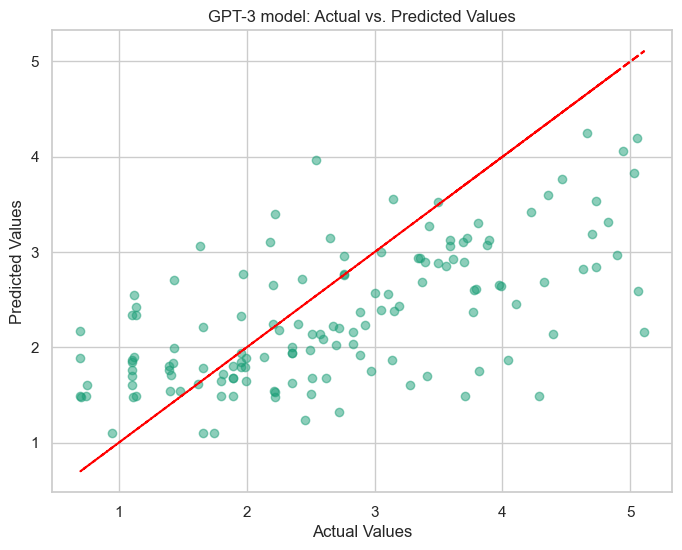

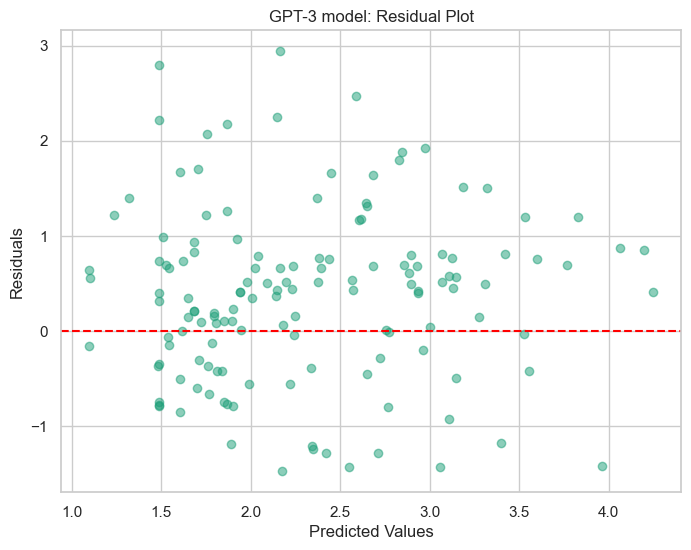

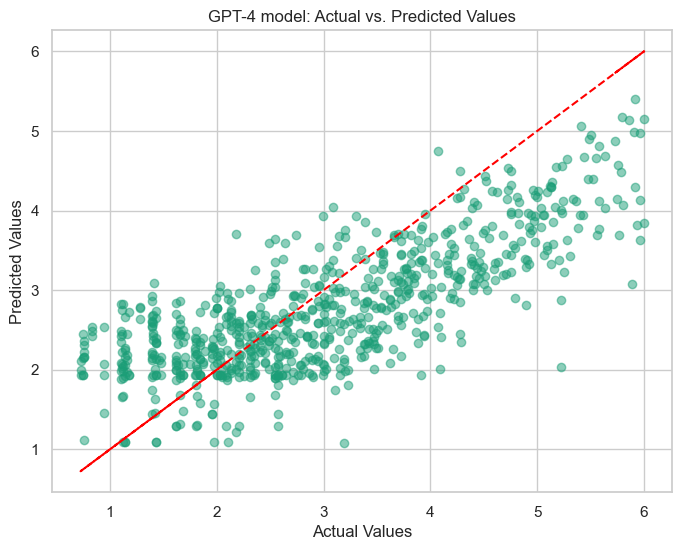

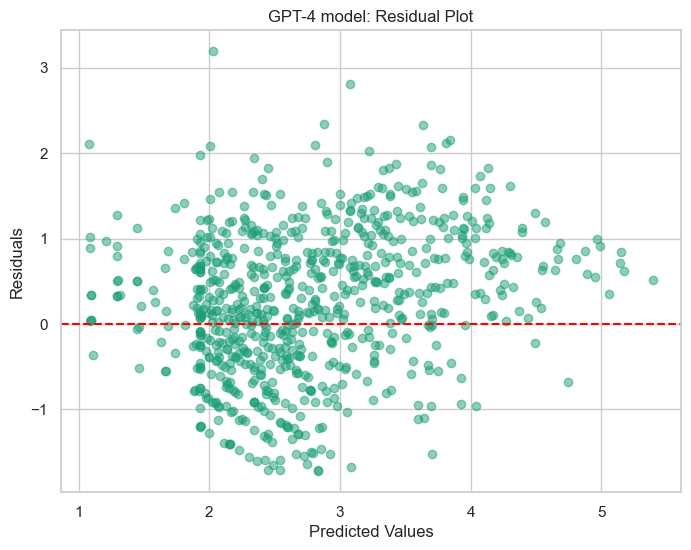

In [386]:
# Plot accuracy of the models
def plot_accuracy(model, name):
    actual_values = model['y_actual']
    predicted_values = model['y_pred']

    # Scatter plot of actual versus predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.5)
    plt.plot(actual_values, actual_values, color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(name + ": Actual vs. Predicted Values")
    plt.grid(True)
    plt.show()

    # Residual plot
    residuals = actual_values - predicted_values
    plt.figure(figsize=(8, 6))
    plt.scatter(predicted_values, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(name + ": Residual Plot")
    plt.grid(True)
    plt.show()

    # Coefficient plot (if coefficients are available in the MLflow run)
    if "coefficients" in model:
        coefficients = model["coef"]
        plt.figure(figsize=(8, 6))
        sns.barplot(x=coefficients.index, y=coefficients.values)
        plt.xlabel("Independent Variables")
        plt.ylabel("Coefficients")
        plt.title("Coefficient Plot")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
plot_accuracy(model=gpt3_model, name='GPT-3 model')
plot_accuracy(model=gpt4_model, name='GPT-4 model')

# Feature Plots

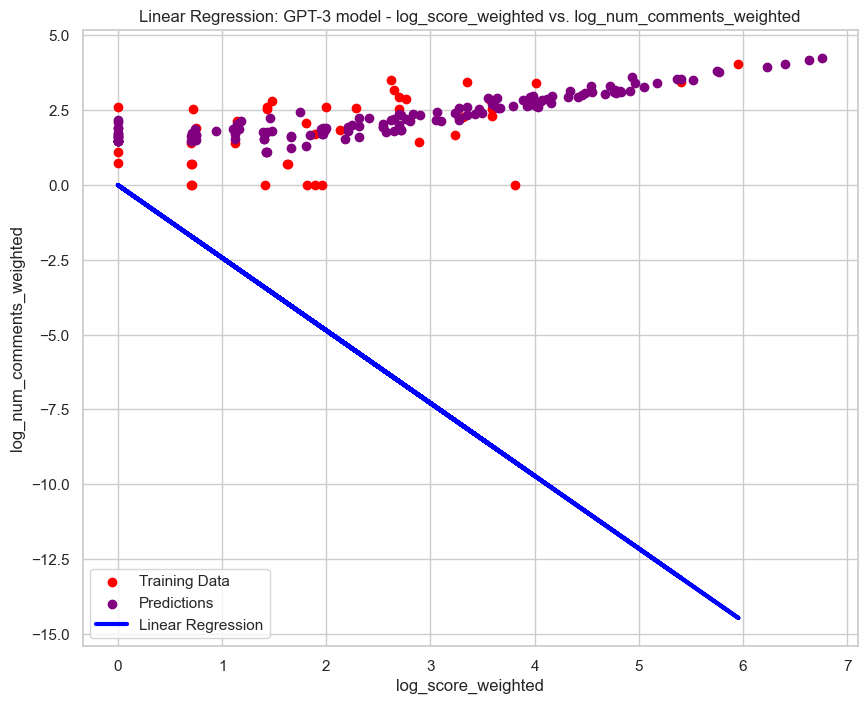

log_score_weighted=-2.4299314475945244


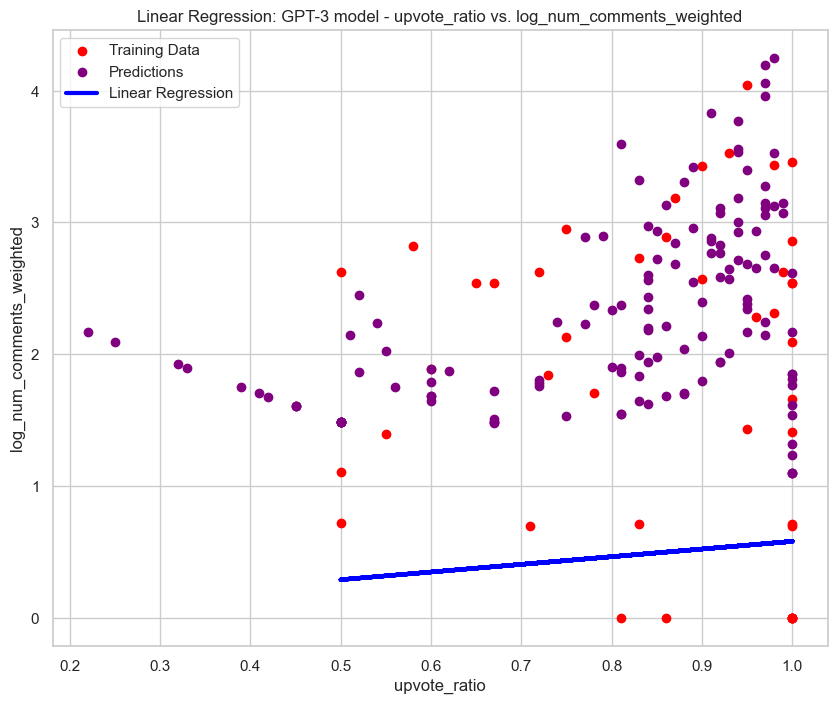

upvote_ratio=0.5810056864391111


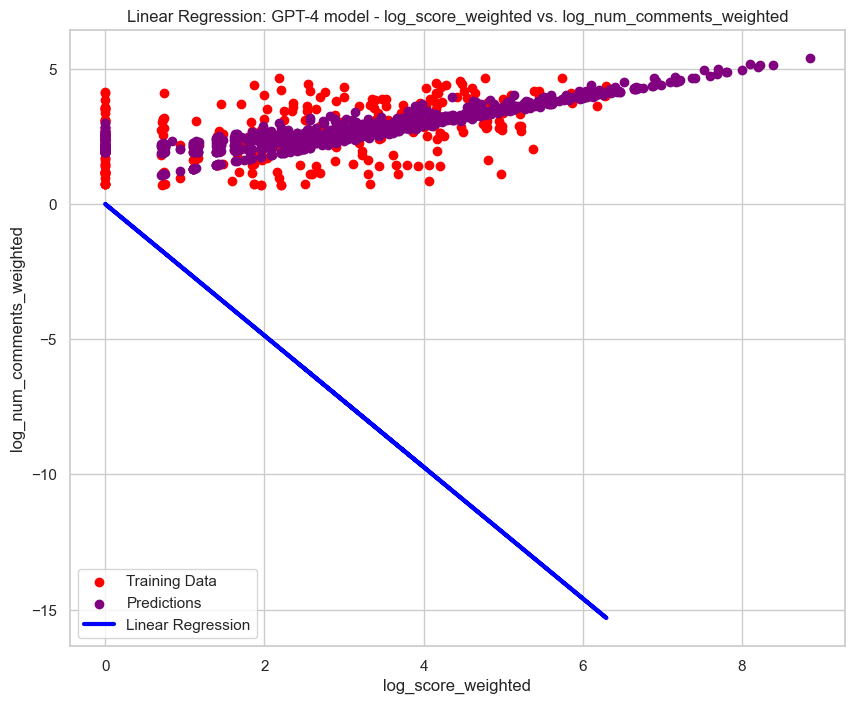

log_score_weighted=-2.4306920620638173


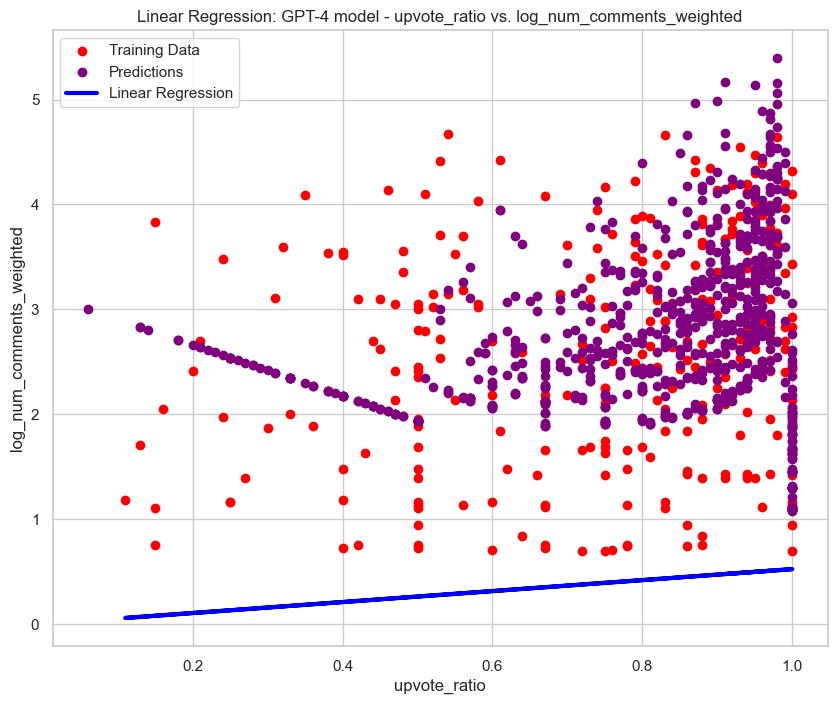

upvote_ratio=0.5232452364922602


In [387]:
def plot_features(model, name):
    for coef in feature_names:
        feature = coef
        plt.scatter(model['X'][feature], model['y'], color='red', label='Training Data')
        plt.scatter(model['X_test'][feature], model['y_pred'], color='purple', label='Predictions')
        y_fit = model['X'][feature] * model['coef'][0][feature_names.index(feature)]
        plt.plot(model['X'][feature], y_fit, color='blue', linewidth=3, label='Linear Regression')
        plt.xlabel(f"{feature}")
        plt.ylabel(f"{target_name}")
        plt.title(f"Linear Regression: {name} - {feature} vs. {target_name}")
        plt.legend()
        plt.show()
        print(f"{coef}={model['coef'][0][feature_names.index(coef)]}")
plot_features(model=gpt3_model, name='GPT-3 model')
plot_features(model=gpt4_model, name='GPT-4 model')

# Categorical Distributions

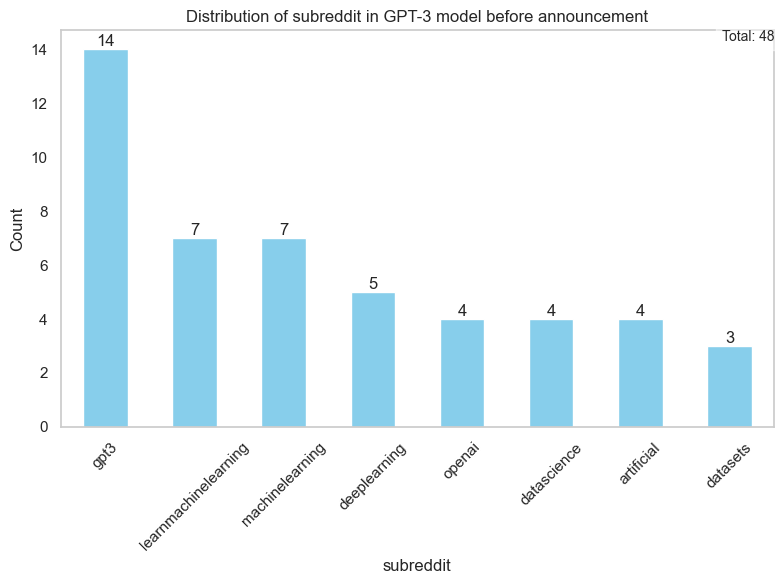

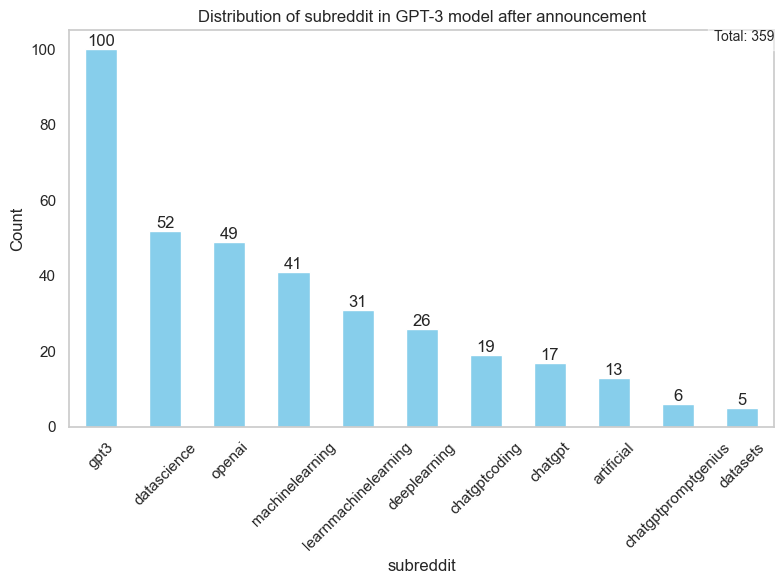

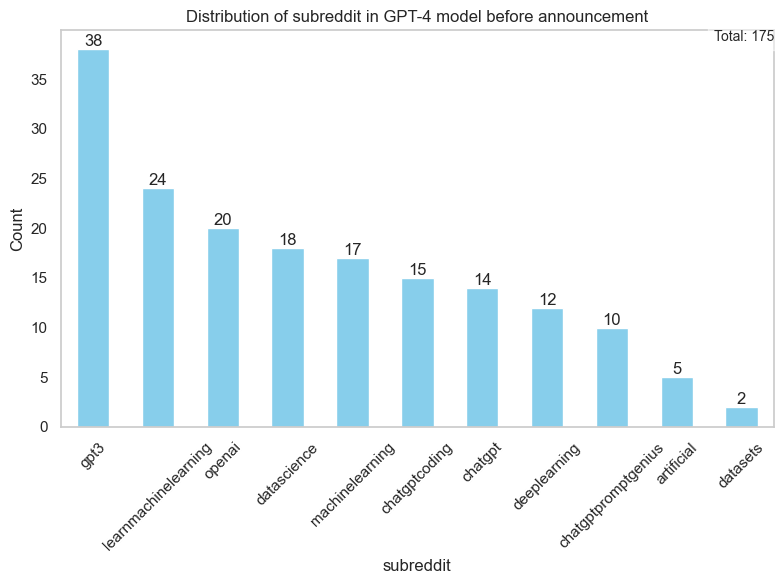

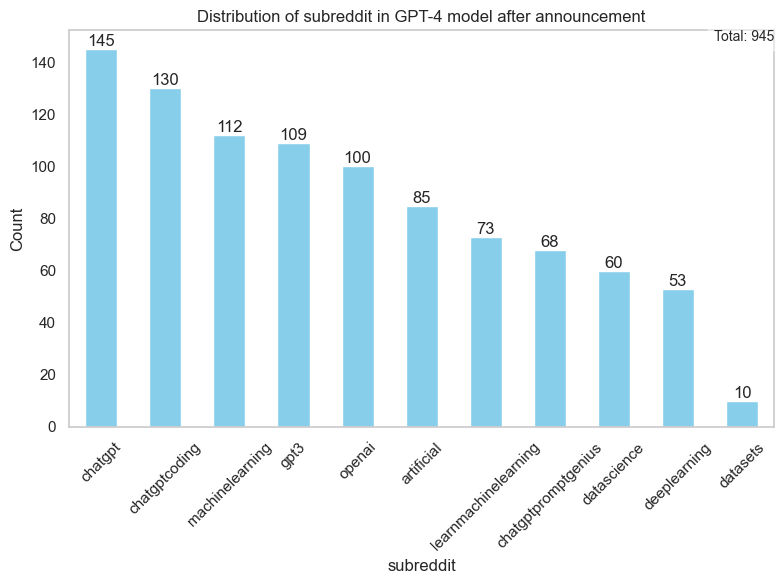

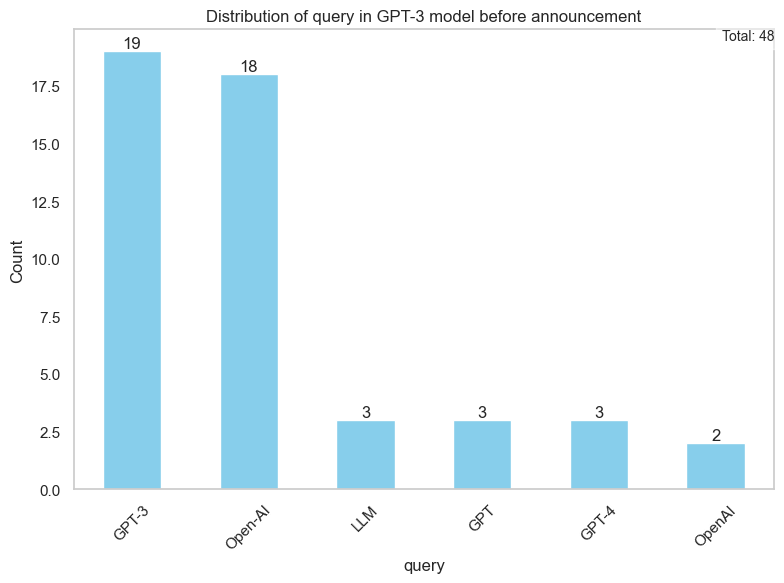

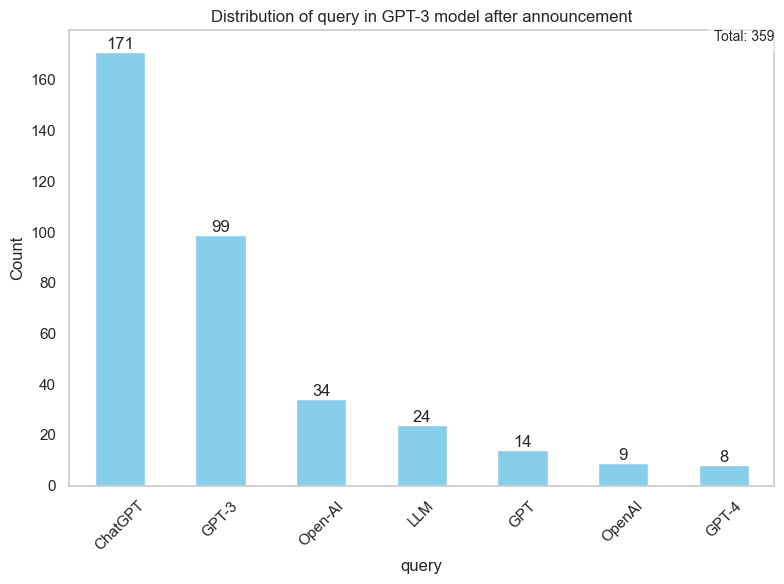

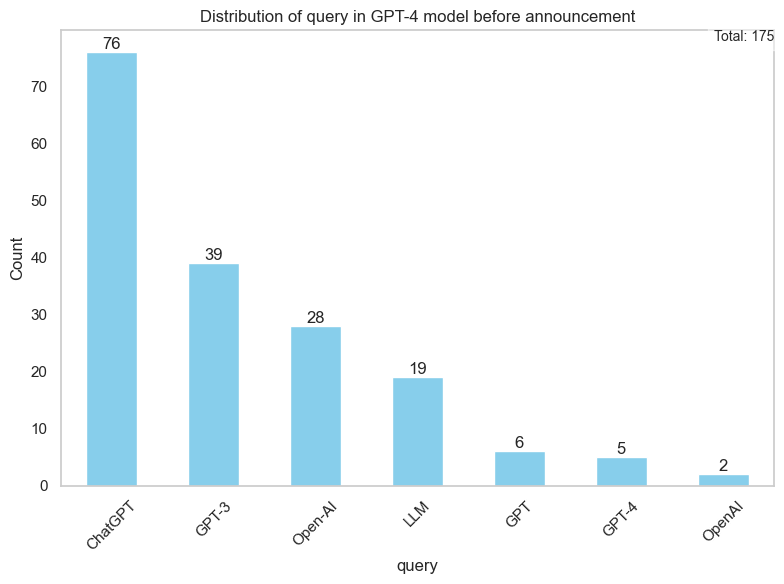

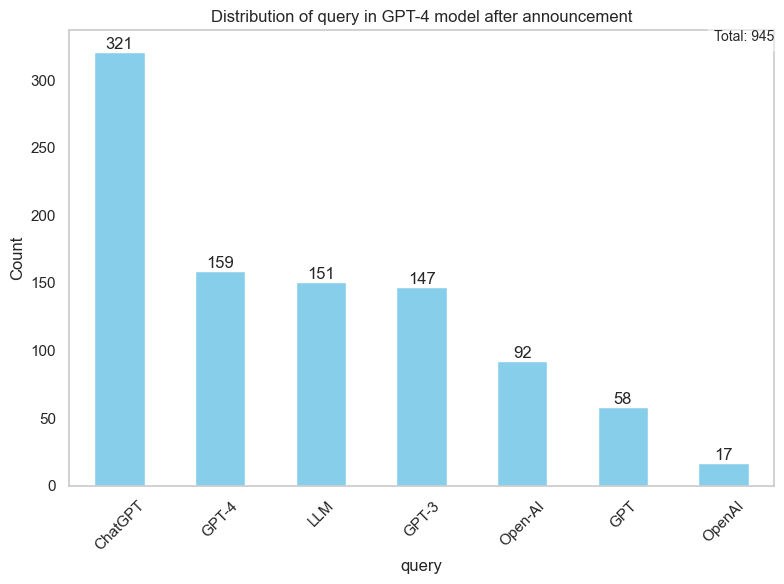

In [388]:
def plot_distributions(dataset, name, category):
    # Count the occurrences of each category value
    category_counts = dataset[category].value_counts()

    # Plot the distribution as a bar chart
    plt.figure(figsize=(8, 6))
    ax = category_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {category} in {name}')
    plt.xlabel(category)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    ax.grid(False)  # Remove gridlines


    # Annotate each bar with its count
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')
        
    # Add total count outside the plot
    total_count = dataset[category].count()
    plt.text(1, 1, f'Total: {total_count}', ha='right', va='top', transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
for category in ['subreddit', 'query']:
    plot_distributions(dataset=df_gpt3_before, name='GPT-3 model before announcement', category=category)
    plot_distributions(dataset=df_gpt3_after, name='GPT-3 model after announcement', category=category)
    plot_distributions(dataset=df_gpt4_before, name='GPT-4 model before announcement', category=category)
    plot_distributions(dataset=df_gpt4_after, name='GPT-4 model after announcement', category=category)

# Heatmap of MLflow runs

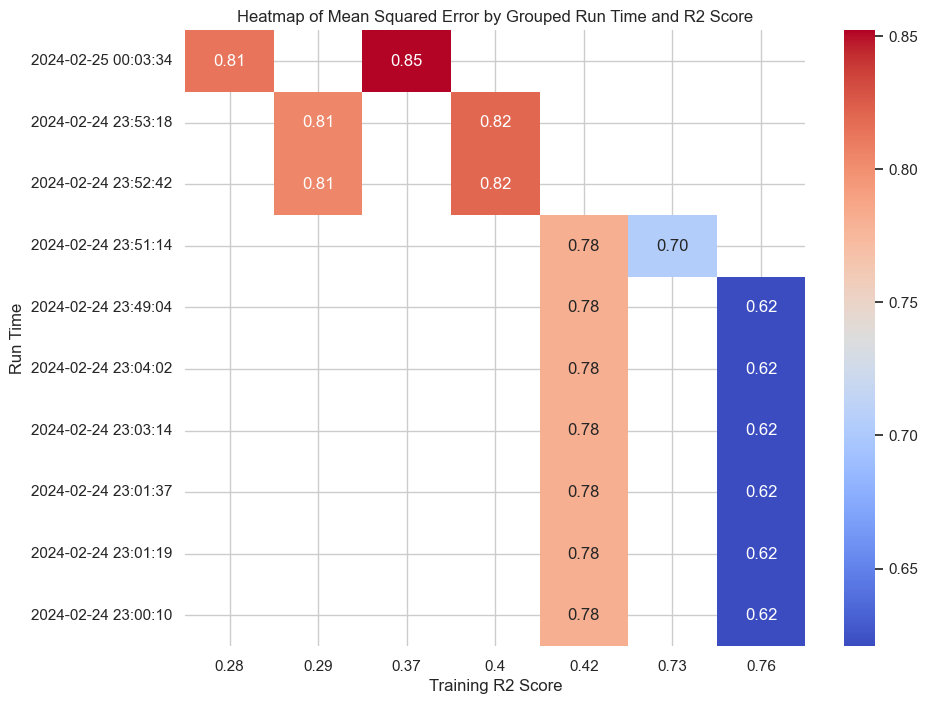

In [389]:
# Fetch the data from MLflow
experiments = mlflow.search_runs()

# Convert 'start_time' column to datetime
experiments['start_time'] = pd.to_datetime(experiments['start_time'])
# Format 'start_time' to include date, hour, minute, and second
experiments['start_time'] = experiments['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Trim the values in 'metrics.training_r2_score' to two decimal places
experiments['metrics.training_r2_score'] = experiments['metrics.training_r2_score'].apply(lambda x: round(x, 2))

# Sort by 'start_time' column in descending order
experiments_sorted = experiments.sort_values(by='start_time', ascending=False)

# Take every 4 experiments and collate them
experiments_sorted['start_time_grouped'] = experiments_sorted.groupby(experiments_sorted.index // 2)['start_time'].transform(lambda x: x.iloc[0])

# Take the most recent 5 experiments
num_experiments = 10
recent_experiments = experiments_sorted.head(num_experiments*2)

# Organize the data into a DataFrame
heatmap_data = recent_experiments.pivot_table(index='start_time_grouped', columns='metrics.training_r2_score', values='metrics.training_mean_squared_error')

# Sort the index in descending order
heatmap_data = heatmap_data.sort_index(ascending=False)

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Heatmap of Mean Squared Error by Grouped Run Time and R2 Score')
plt.xlabel('Training R2 Score')
plt.ylabel('Run Time')
plt.show()